# This notebook contains the necessary script to identify GC stars in APOGEE, using the Baumgardt et al structure and kinematic values for GCs, and the Harris et al 2010 catalogue of GC metallicities

This code will only run assuming you have python 3 installed with the following modules: matplotlib, numpy, astropy, and tqdm. It also assumes that you have the Baumgardt table of GC fundamental parameters (found here https://people.smp.uq.edu.au/HolgerBaumgardt/globular/) and the Harris Galactic GC catalogue (see here http://physwww.mcmaster.ca/~harris/mwgc.dat) merged into a single file. Other than that, you will just need the APOGEE catalogue (or any Milky Way star catalogue with positions, radial velocities and metallicities) that you wish to find GCs in

In [1]:
# load in the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from astropy.io import fits

# We will first load in the crossmatched Harris 2010+ Baumgardt et al catalogue

Note: I used Topcat to get this crossmatched catalogue

In [2]:
# load in the cross-matched harris+Baumgardt catalogue
harris_gc = fits.open('/Users/danny/Desktop/apogee-gc/apogee-gc-complete/data/harris+baumgardt.fits')
data_gc = harris_gc[1].data

# get the data
names_gc = data_gc.field('Name') #gc name
fe_h_gc = data_gc.field('[Fe/H]')#gc metallicity from Harris
vlos_gc = data_gc.field('rad_vel') #gc radial velocity from Baumgardt
rc_gc = data_gc.field('rc') #gc core radius from Baumgardt
rt_gc = data_gc.field('rt') #gc tidal radius from Baumgardt
glon_gc = data_gc.field('l') #gc longitude from Harris
glat_gc = data_gc.field('b') #gc latitude from Harris
rsun_gc = data_gc.field('R_sun(kpc)') #gc longitude from Harris
vlos_disp_gc = data_gc.field('v_disp') #gc velocity dispersion from Baumgardt
pmra_gc = data_gc.field('pmra')#gc pmra from Baumgardt
pmdec_gc = data_gc.field('pmdec')#gc pmdec from Baumgardt
pmra_gc_err = data_gc.field('pmra_err')#gc pmra error from Baumgardt
pmdec_gc_err = data_gc.field('pmdec_err')#gc pmdec error from Baumgardt


transform the radius values to parsec

In [3]:
rsun_gc = np.asarray(rsun_gc,dtype=float) 
rsun_gc = rsun_gc*1000 #transform distance into parsecs

calculate the tidal radius

In [4]:
rt_degrees = np.tan(rt_gc/rsun_gc)*180/np.pi #now we have tidal radius in degrees

In [5]:
# load in the harris gc ids
harris = fits.open('/Users/danny/Desktop/Master/data/harris2010.fits')
data_h = harris[1].data
names_h = data_h.field('ID') #gc name
fehs_h = data_h.field('[Fe/H]') #gc met
# eliminate the spaces in the names
names_h = names_h.replace(" ","")

In [6]:
# Apply a mask to eliminate any [Fe/H] = -9999 abundances
mask_fsr1753 = fe_h_gc!='-9999'
names_gc = names_gc[mask_fsr1753]
fe_h_gc = fe_h_gc[mask_fsr1753]
vlos_gc = vlos_gc[mask_fsr1753]
rc_gc = rc_gc[mask_fsr1753]
rt_gc = rt_gc[mask_fsr1753]
glon_gc = glon_gc[mask_fsr1753]
glat_gc = glat_gc[mask_fsr1753]
vlos_disp_gc = vlos_disp_gc[mask_fsr1753]
pmra_gc = pmra_gc[mask_fsr1753]
pmdec_gc = pmdec_gc[mask_fsr1753]
pmra_gc_err = pmra_gc_err[mask_fsr1753]
pmdec_gc_err = pmdec_gc_err[mask_fsr1753]
rt_d_gc = rt_degrees[mask_fsr1753]

In [7]:
# load in the APOGEE (or any other) catalogue
file = 'DR17_McMillan.fits'
apogee = fits.open('/Users/danny/Desktop/Master/data/'+file)
data = apogee[1].data
# get the data
apogee_id = data.field('APOGEE_ID') # ids
fe_h = data.field('FE_H')  # metallicities
vlos = data.field('VHELIO_AVG')  # radial velocities
glon = data.field('GLON')  # longitudes 
glat = data.field('GLAT')  # latitudes

In [8]:
# Change the list array to float
fe_h_gc = np.asarray(fe_h_gc,dtype=float)

# Find stars associated to Galactic GCs

In [9]:
# set your save path directory to where all the GC txt files with the APOGEE ids will be saved
savepath = '/Users/danny/Desktop/apogee-gc/dr17/unclipped/'

In [12]:
# loop through all the GCs and find stars in APOGEE given their radial velocities and projected distances
from math import nan
for indx2,j in tqdm.tqdm(enumerate(glon_gc)):
    a=indx2 #get the index
    b = names_gc[a] #find the GC name associated to that index
    gcs_indx = [] #create an array to which associate a gc name to a star
    for indx,i in enumerate(range(glon.shape[0]-1)):
#           calculate the projected distance of a star to the cluster
        d = np.sqrt(((glon[i]-glon_gc[a])*(np.cos(glat_gc[a]*np.pi/180)))**2+((glat[i]-glat_gc[a])**2))
#     if the difference in the radial velocity of the star and that of the GC
#     is within 2 values of the velocity dispersion of the cluster, we will accept the star as a preliminary candidate
        if (np.fabs(vlos[i]-vlos_gc[a])<=(2*vlos_disp_gc[a])):
#         it must also have a projected distance within 2 values of the GC tidal radius (in degrees)
            if d<=((2*rt_d_gc[a])):
                    gcs_indx.append(indx)
    print('There are '+str(len(gcs_indx))+' stars in '+str(b)) # print how many stars are identified in each GC
    gcs_id = apogee_id[gcs_indx].T
    gc_name = np.array([b]*len(gcs_id)).T
    total = ((gc_name,gcs_id))
    rec = np.recarray(len(gcs_id), dtype=[('apogee_id',object),('name', object)])
    rec['apogee_id'] = gcs_id
    rec['name'] = gc_name
    np.savetxt(savepath+b+'.txt',rec,fmt='%s')     # save each GC file as a txt file in your out directory





0it [00:00, ?it/s]


1it [00:18, 18.51s/it]

There are 353 stars in NGC104





2it [00:36, 18.47s/it]

There are 49 stars in NGC288





3it [00:55, 18.47s/it]

There are 74 stars in NGC362





4it [01:13, 18.42s/it]

There are 0 stars in Whiting1





5it [01:31, 18.24s/it]

There are 0 stars in NGC1261





6it [01:49, 18.23s/it]

There are 0 stars in Pal1





7it [02:07, 18.18s/it]

There are 0 stars in AM1





8it [02:25, 18.11s/it]

There are 0 stars in Eridanus





9it [02:43, 18.14s/it]

There are 0 stars in Pal2





10it [03:02, 18.24s/it]

There are 63 stars in NGC1851





11it [03:20, 18.24s/it]

There are 29 stars in NGC1904





12it [03:39, 18.35s/it]

There are 0 stars in NGC2298





13it [03:58, 18.54s/it]

There are 82 stars in NGC2419





14it [04:17, 18.62s/it]

There are 0 stars in Pyxis





15it [04:35, 18.66s/it]

There are 111 stars in NGC2808





16it [04:53, 18.52s/it]

There are 0 stars in E3





17it [05:12, 18.65s/it]

There are 0 stars in Pal3





18it [05:32, 18.78s/it]

There are 210 stars in NGC3201





19it [05:51, 18.87s/it]

There are 0 stars in Pal4





20it [06:09, 18.79s/it]

There are 3 stars in NGC4147





21it [06:28, 18.71s/it]

There are 0 stars in NGC4372





22it [06:46, 18.72s/it]

There are 3 stars in Rup106





23it [07:06, 18.94s/it]

There are 41 stars in NGC4590





24it [07:25, 18.86s/it]

There are 0 stars in NGC4833





25it [07:45, 19.20s/it]

There are 46 stars in NGC5024





26it [08:03, 19.00s/it]

There are 15 stars in NGC5053





27it [08:21, 18.75s/it]

There are 1439 stars in NGC5139





28it [08:39, 18.47s/it]

There are 300 stars in NGC5272





29it [08:58, 18.55s/it]

There are 3 stars in NGC5286





30it [09:17, 18.63s/it]

There are 0 stars in AM4





31it [09:35, 18.44s/it]

There are 16 stars in NGC5466





32it [09:52, 18.25s/it]

There are 64 stars in NGC5634





33it [10:10, 18.12s/it]

There are 0 stars in NGC5694





34it [10:29, 18.35s/it]

There are 0 stars in IC4499





35it [10:47, 18.27s/it]

There are 0 stars in NGC5824





36it [11:06, 18.34s/it]

There are 5 stars in Pal5





37it [11:24, 18.25s/it]

There are 0 stars in NGC5897





38it [11:42, 18.21s/it]

There are 294 stars in NGC5904





39it [12:00, 18.14s/it]

There are 2 stars in NGC5927





40it [12:20, 18.85s/it]

There are 0 stars in NGC5946





41it [12:43, 19.92s/it]

There are 0 stars in NGC5986





42it [13:02, 19.79s/it]

There are 0 stars in Pal14





43it [13:20, 19.27s/it]

There are 0 stars in Lynga7





44it [13:38, 18.94s/it]

There are 63 stars in NGC6093





45it [13:56, 18.58s/it]

There are 263 stars in NGC6121





46it [14:14, 18.29s/it]

There are 0 stars in NGC6101





47it [14:33, 18.52s/it]

There are 0 stars in NGC6144





48it [14:51, 18.53s/it]

There are 0 stars in NGC6139





49it [15:11, 18.71s/it]

There are 0 stars in Terzan3





50it [15:29, 18.77s/it]

There are 104 stars in NGC6171





51it [15:48, 18.63s/it]

There are 147 stars in NGC6205





52it [16:06, 18.64s/it]

There are 13 stars in NGC6229





53it [16:25, 18.66s/it]

There are 207 stars in NGC6218





54it [16:43, 18.52s/it]

There are 0 stars in NGC6235





55it [17:02, 18.50s/it]

There are 103 stars in NGC6254





56it [17:20, 18.34s/it]

There are 0 stars in NGC6256





57it [17:38, 18.36s/it]

There are 0 stars in Pal15





58it [17:57, 18.41s/it]

There are 0 stars in NGC6266





59it [18:16, 18.53s/it]

There are 89 stars in NGC6273





60it [18:36, 19.13s/it]

There are 0 stars in NGC6284





61it [18:55, 19.14s/it]

There are 0 stars in NGC6287





62it [19:15, 19.25s/it]

There are 20 stars in NGC6293





63it [19:33, 18.82s/it]

There are 39 stars in NGC6304





64it [19:52, 18.88s/it]

There are 33 stars in NGC6316





65it [20:10, 18.80s/it]

There are 97 stars in NGC6341





66it [20:29, 18.78s/it]

There are 5 stars in NGC6325





67it [20:48, 18.85s/it]

There are 0 stars in NGC6333





68it [21:07, 18.78s/it]

There are 0 stars in NGC6342





69it [21:24, 18.43s/it]

There are 0 stars in NGC6356





70it [21:42, 18.11s/it]

There are 0 stars in NGC6355





71it [21:59, 18.03s/it]

There are 0 stars in NGC6352





72it [22:17, 18.03s/it]

There are 0 stars in IC1257





73it [22:35, 17.92s/it]

There are 4 stars in Terzan2





74it [22:52, 17.76s/it]

There are 0 stars in NGC6366





75it [23:10, 17.79s/it]

There are 5 stars in Terzan4





76it [23:28, 17.84s/it]

There are 22 stars in HP1





77it [23:47, 18.18s/it]

There are 0 stars in NGC6362





78it [24:06, 18.33s/it]

There are 15 stars in Liller1





79it [24:25, 18.58s/it]

There are 89 stars in NGC6380





80it [24:44, 18.58s/it]

There are 1 stars in Terzan1





81it [25:02, 18.58s/it]

There are 6 stars in Ton2





82it [25:21, 18.74s/it]

There are 92 stars in NGC6388





83it [25:40, 18.86s/it]

There are 6 stars in NGC6402





84it [25:59, 18.90s/it]

There are 12 stars in NGC6401





85it [26:19, 18.97s/it]

There are 251 stars in NGC6397





86it [26:37, 18.65s/it]

There are 19 stars in Pal6





87it [26:55, 18.62s/it]

There are 0 stars in NGC6426





88it [27:13, 18.41s/it]

There are 3 stars in Djorg1





89it [27:32, 18.45s/it]

There are 47 stars in Terzan5





90it [27:50, 18.34s/it]

There are 0 stars in NGC6440





91it [28:08, 18.29s/it]

There are 94 stars in NGC6441





92it [28:26, 18.16s/it]

There are 1 stars in Terzan6





93it [28:45, 18.44s/it]

There are 4 stars in NGC6453





94it [29:04, 18.56s/it]

There are 7 stars in UKS1





95it [29:22, 18.52s/it]

There are 0 stars in NGC6496





96it [29:39, 18.20s/it]

There are 1 stars in Terzan9





97it [29:58, 18.37s/it]

There are 27 stars in NGC6517





98it [30:17, 18.39s/it]

There are 75 stars in NGC6522





99it [30:36, 18.70s/it]

There are 0 stars in NGC6535





100it [30:55, 18.83s/it]

There are 5 stars in NGC6528





101it [31:14, 18.91s/it]

There are 19 stars in NGC6539





102it [31:35, 19.49s/it]

There are 23 stars in NGC6540





103it [31:56, 19.78s/it]

There are 400 stars in NGC6544





104it [32:15, 19.69s/it]

There are 0 stars in NGC6541





105it [32:35, 19.65s/it]

There are 71 stars in NGC6553





106it [32:54, 19.47s/it]

There are 6 stars in NGC6558





107it [33:12, 19.02s/it]

There are 0 stars in IC1276





108it [33:30, 18.79s/it]

There are 37 stars in NGC6569





109it [33:48, 18.48s/it]

There are 9 stars in BH261





110it [34:06, 18.50s/it]

There are 0 stars in NGC6584





111it [34:25, 18.68s/it]

There are 0 stars in NGC6624





112it [34:44, 18.53s/it]

There are 0 stars in NGC6626





113it [35:02, 18.54s/it]

There are 0 stars in NGC6638





114it [35:21, 18.54s/it]

There are 0 stars in NGC6637





115it [35:39, 18.47s/it]

There are 6 stars in NGC6642





116it [35:57, 18.33s/it]

There are 0 stars in NGC6652





117it [36:16, 18.52s/it]

There are 426 stars in NGC6656





118it [36:35, 18.64s/it]

There are 0 stars in Pal8





119it [36:54, 18.71s/it]

There are 0 stars in NGC6681





120it [37:12, 18.59s/it]

There are 0 stars in NGC6712





121it [37:31, 18.69s/it]

There are 920 stars in NGC6715





122it [37:48, 18.33s/it]

There are 0 stars in NGC6717





123it [38:06, 18.05s/it]

There are 13 stars in NGC6723





124it [38:23, 17.93s/it]

There are 0 stars in NGC6749





125it [38:41, 17.74s/it]

There are 235 stars in NGC6752





126it [38:58, 17.50s/it]

There are 18 stars in NGC6760





127it [39:14, 17.29s/it]

There are 0 stars in NGC6779





128it [39:31, 17.12s/it]

There are 0 stars in Terzan7





129it [39:48, 17.02s/it]

There are 9 stars in Pal10





130it [40:05, 16.93s/it]

There are 0 stars in Arp2





131it [40:21, 16.87s/it]

There are 99 stars in NGC6809





132it [40:38, 16.84s/it]

There are 0 stars in Terzan8





133it [40:55, 16.82s/it]

There are 0 stars in Pal11





134it [41:12, 16.82s/it]

There are 161 stars in NGC6838





135it [41:29, 16.80s/it]

There are 0 stars in NGC6864





136it [41:45, 16.79s/it]

There are 0 stars in NGC6934





137it [42:02, 16.81s/it]

There are 0 stars in NGC6981





138it [42:19, 16.81s/it]

There are 0 stars in NGC7006





139it [42:36, 16.85s/it]

There are 231 stars in NGC7078





140it [42:53, 16.95s/it]

There are 144 stars in NGC7089





141it [43:10, 16.88s/it]

There are 0 stars in NGC7099





142it [43:27, 16.85s/it]

There are 0 stars in Pal12





143it [43:43, 16.83s/it]

There are 0 stars in Pal13





144it [44:00, 18.34s/it]

There are 0 stars in NGC7492


# Now load in all the separate GC files and concatenate them into one big file

In [12]:
# load all the initial GC text files (containing the APOGEE IDs) and concatenate them
import glob
import sys
files = glob.glob(savepath+'*.txt')
complete=[]
for i in files:
    file = np.array(np.loadtxt(i,dtype='str'))
    complete.extend(file)

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/unclipped/AM1.txt"
  
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/unclipped/AM4.txt"
  
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/unclipped/Arp2.txt"
  
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/unclipped/E3.txt"
  
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/unclipped/Eridanus.txt"
  
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: loadtxt

Note: The command above will return a bunch of warnings about empty files (where there are no GC stars for that GC). Ignore this, I still haven't figured out how to set an ignore to those messages...

# And save the big file in the same directory

In [15]:
# save the full sample together
np.savetxt(savepath+'complete.txt',complete,fmt='%s')

# Now I recommend using a software program like Topcat to merge the GC ids with the APOGEE data file. Once you have merged the files, save it as a fits file and load in the new merged file

In [36]:
apogee2 = fits.open(savepath+'merged_dr17.fits')
data2 = apogee2[1].data
fehs = data2.field('FE_H')
sifes = data2.field('SI_FE')
mgfes = data2.field('MG_FE')
nfes = data2.field('N_FE')
cfes = data2.field('C_FE')
name = data2.field('gc_name')
# FOR APOGEE DATA: Mask out stars with bad Mg,Si,N,C,Fe abundances
mask = (sifes>-10.)&(fehs>-10.)&(mgfes>-10.)&(nfes>-10.)&(cfes>-10.)
data2 = data2[mask]
# Check to see how many stars and GCs you have in the preliminary GC sample, before performing the sigma clipping procedure
print('There are '+str(len(data2))+' preliminary GC stars with reliable abundances')
from collections import Counter
names = (Counter(name[mask]).keys())
print('There are '+str(len(names))+' preliminary GCs which have reliable abundances')

There are 5805 preliminary GC stars with reliable abundances
There are 73 preliminary GCs which have reliable abundances


# Now that we have obtained all the stars in our catalogue which satisfy the position and radial velocity conditions, we will begin the sigma clipping procedure of the MDF distributions following the method in Horta et al (2020)

# Run the sigma clipping method

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  r

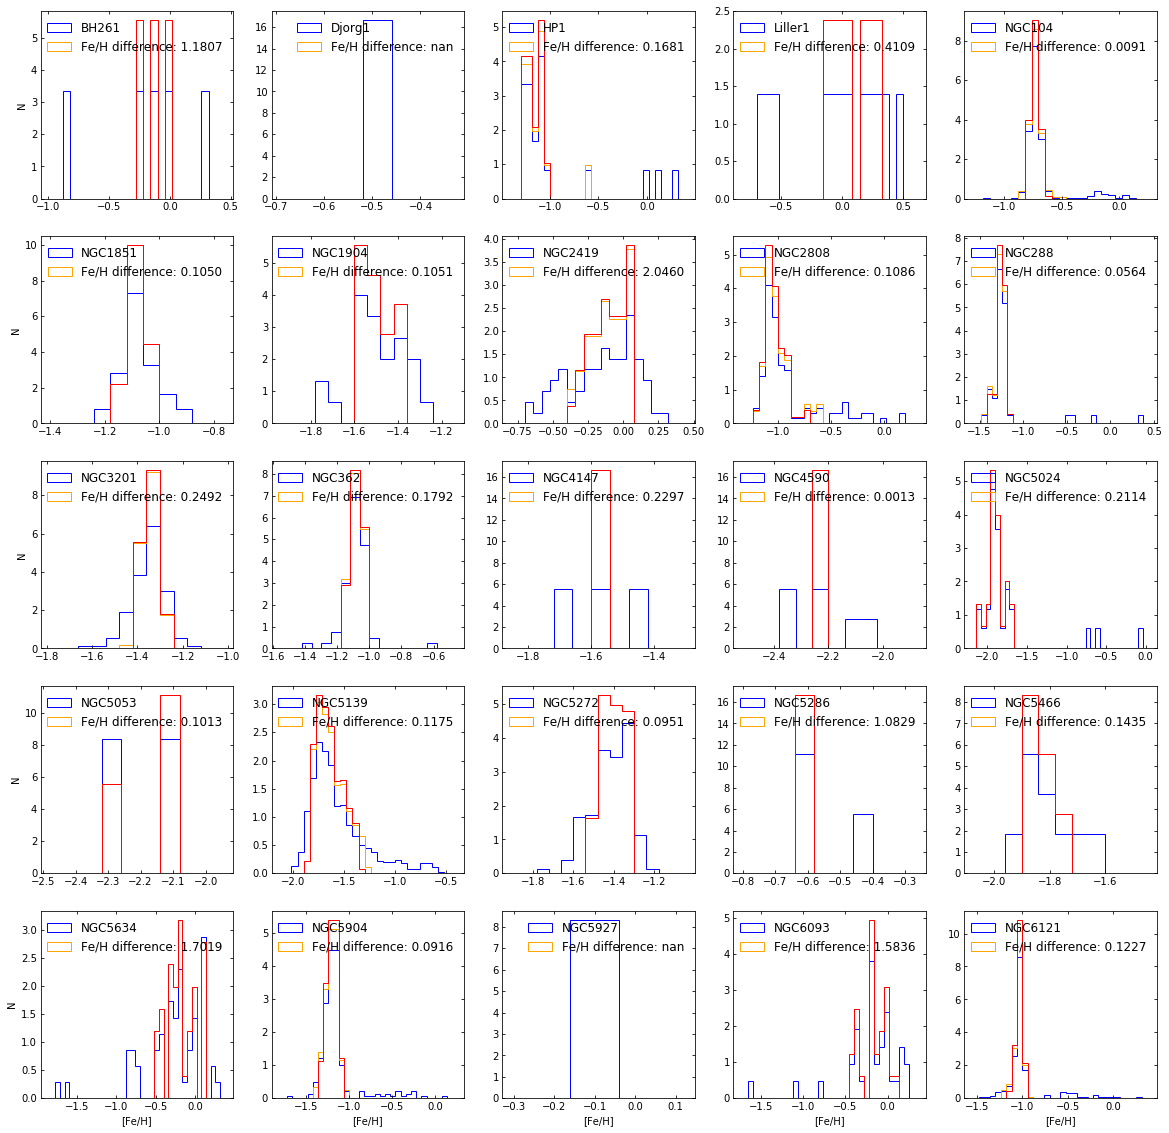

In [19]:
import matplotlib.gridspec as grid
# loop through the data and refine our GC sample in APOGEE using the MDF clipping method
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = grid.GridSpec(5,5)
p = 0
names = np.unique(name)
# since there are 73 GCs in the preliminary sample
# loop over three batches of 25 GCs each to look at the MDF distribution and the sigma clipping procedure
names_1 = names[:25]
names_2 = names[25:50]
names_3 = names[50:]

for indx,i in enumerate(names_1):
    if i in data2['gc_name']:
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, Radial velocity)
        fehs = data2['FE_H']
        vlos = data2['VHELIO_AVG']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        vlos = vlos[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         determine the mean and sigma Fe/H values
        mean = np.mean(fehs)
        sigma = np.std(fehs)
#         select only those stars within 1 sigma from the mean [Fe/H] value
        fehs2 = fehs[np.fabs(mean-fehs)<(1.*sigma)]
        vlos2 = vlos[np.fabs(mean-fehs)<(1.*sigma)]
        names2 = gc_name[np.fabs(mean-fehs)<(1.*sigma)]
#         repeat the procedure and get the new mean and sigma [Fe/H] values to compare
        mean2 = np.mean(fehs2)
        sigma2 = np.std(fehs2)
#         again mask those stars which are within 2 sigmas of the new mean
        fehs3 = fehs2[np.fabs(mean2-fehs2)<=(2.*sigma2)]
        vlos3 = vlos2[np.fabs(mean2-fehs2)<(2.*sigma2)]
        names3 = names2[np.fabs(mean2-fehs2)<(2.*sigma2)]
#         calculate the final mean and sigma [Fe/H] values
        mean3 = np.mean(fehs3)
        sigma3 = np.std(fehs3)
        diff = np.array(np.fabs(mean3-fehs_h[names_h==i]))
#         plot the distributions to see what they look like
    ax = fig.add_subplot(gs[p])
    ax.hist(fehs,50,range=(-2.5,0.5),histtype='step',color='b',label=str(i),density=True)
    ax.hist(fehs2,50,range=(-2.5,0.5),histtype='step',color='orange',density=True,label='Fe/H difference: '+str("%.4f" % diff))
    ax.hist(fehs3,50,range=(-2.5,0.5),histtype='step',color='red',density=True)
    ax.legend(loc='best',frameon=False,fontsize=12)
    ax.set_xlim(np.min(fehs)-0.2,np.max(fehs)+0.2)
    p+=1
axis = fig.axes
axis[0].set(ylabel='N')
axis[5].set(ylabel='N')
axis[10].set(ylabel='N')
axis[15].set(ylabel='N')
axis[20].set(ylabel='N')
axis[20].set(xlabel='[Fe/H]')
axis[21].set(xlabel='[Fe/H]')
axis[22].set(xlabel='[Fe/H]')
axis[23].set(xlabel='[Fe/H]')
axis[24].set(xlabel='[Fe/H]')

axis[0].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[1].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[2].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[3].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[4].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[5].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[6].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[7].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[8].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[9].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[10].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[11].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[12].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[13].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[14].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[15].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[16].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[17].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[18].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[19].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[20].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[21].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[22].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[23].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[24].tick_params(direction='in',axis='both',length=3,right=True,top=True)

gs.update(wspace=0.2,hspace=0.2)
# this is in case you wish to save the plot...
# plt.savefig('fig1', format='pdf', dpi=400, bbox_inches='tight')



Note: The code will plot the different sigma clips, where blue is the raw distribution, yellow is the resulting population after the first sigma clip, and red is the population after the second sigma clip. It will also list the GC name and metallicity difference between the final [Fe/H] mean value and the Harris [Fe/H] value for that GC. In Horta et al (2020), we eliminated any stars that presented a clipped MDF mean 0.5 away from the Harris catalogue value. For those that satisfy this criteria, we studied each GC MDF individually and then selected either the raw, 1-$\sigma$ or 2-$\sigma$ clipped distribution as our final distribution for each GC.

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


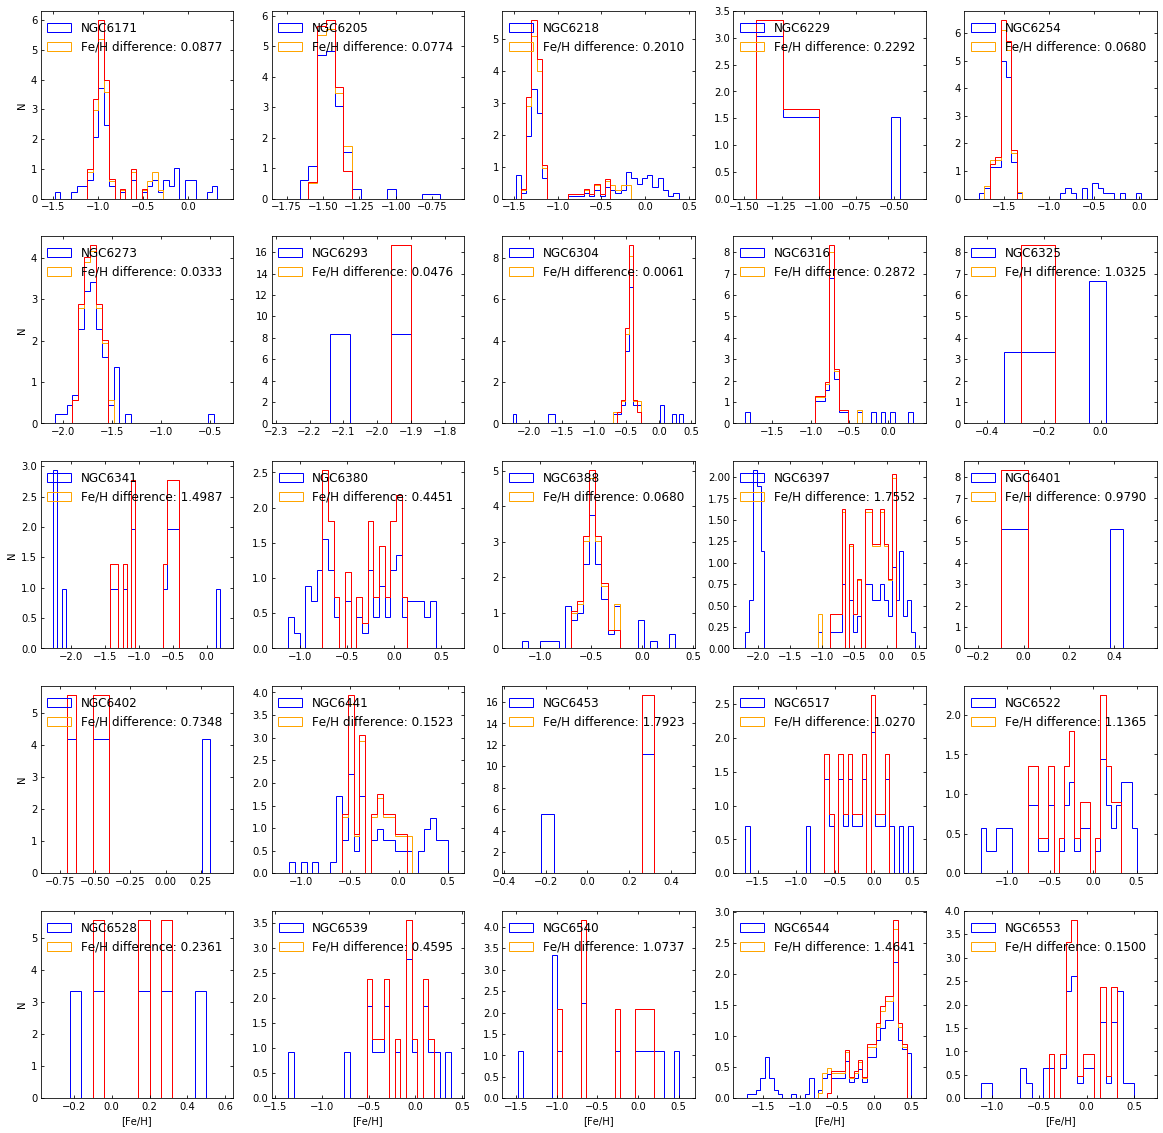

In [21]:
import matplotlib.gridspec as grid

# loop through the data and refine our GC sample in APOGEE using the MDF clipping method
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = grid.GridSpec(5,5)
p = 0
names = np.unique(name)
# loop over three batches of 25 GCs each to look at the MDF distribution and the sigma clipping procedure
names_1 = names[:25]
names_2 = names[25:50]
names_3 = names[50:]

for indx,i in enumerate(names_2):
    if i in data2['gc_name']:
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, Radial velocity)
        fehs = data2['FE_H']
        vlos = data2['VHELIO_AVG']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        vlos = vlos[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         determine the mean and sigma Fe/H values
        mean = np.mean(fehs)
        sigma = np.std(fehs)
#         select only those stars within 1 sigma from the mean [Fe/H] value
        fehs2 = fehs[np.fabs(mean-fehs)<(1.*sigma)]
        vlos2 = vlos[np.fabs(mean-fehs)<(1.*sigma)]
        names2 = gc_name[np.fabs(mean-fehs)<(1.*sigma)]
#         repeat the procedure and get the new mean and sigma [Fe/H] values to compare
        mean2 = np.mean(fehs2)
        sigma2 = np.std(fehs2)
#         again mask those stars which are within 2 sigmas of the new mean
        fehs3 = fehs2[np.fabs(mean2-fehs2)<=(2.*sigma2)]
        vlos3 = vlos2[np.fabs(mean2-fehs2)<(2.*sigma2)]
        names3 = names2[np.fabs(mean2-fehs2)<(2.*sigma2)]
#         calculate the final mean and sigma [Fe/H] values
        mean3 = np.mean(fehs3)
        sigma3 = np.std(fehs3)
        diff = np.array(np.fabs(mean3-fehs_h[names_h==i]))
    ax = fig.add_subplot(gs[p])
    ax.hist(fehs,50,range=(-2.5,0.5),histtype='step',color='b',label=str(i),density=True)
    ax.hist(fehs2,50,range=(-2.5,0.5),histtype='step',color='orange',density=True,label='Fe/H difference: '+str("%.4f" % diff))
    ax.hist(fehs3,50,range=(-2.5,0.5),histtype='step',color='red',density=True)
    ax.legend(loc='best',frameon=False,fontsize=12)
    ax.set_xlim(np.min(fehs)-0.2,np.max(fehs)+0.2)
    p+=1
axis = fig.axes
axis[0].set(ylabel='N')
axis[5].set(ylabel='N')
axis[10].set(ylabel='N')
axis[15].set(ylabel='N')
axis[20].set(ylabel='N')
axis[20].set(xlabel='[Fe/H]')
axis[21].set(xlabel='[Fe/H]')
axis[22].set(xlabel='[Fe/H]')
axis[23].set(xlabel='[Fe/H]')
axis[24].set(xlabel='[Fe/H]')

axis[0].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[1].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[2].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[3].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[4].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[5].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[6].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[7].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[8].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[9].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[10].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[11].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[12].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[13].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[14].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[15].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[16].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[17].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[18].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[19].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[20].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[21].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[22].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[23].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[24].tick_params(direction='in',axis='both',length=3,right=True,top=True)

gs.update(wspace=0.2,hspace=0.2)

# plt.savefig('fig2', format='pdf', dpi=400, bbox_inches='tight')




/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  r

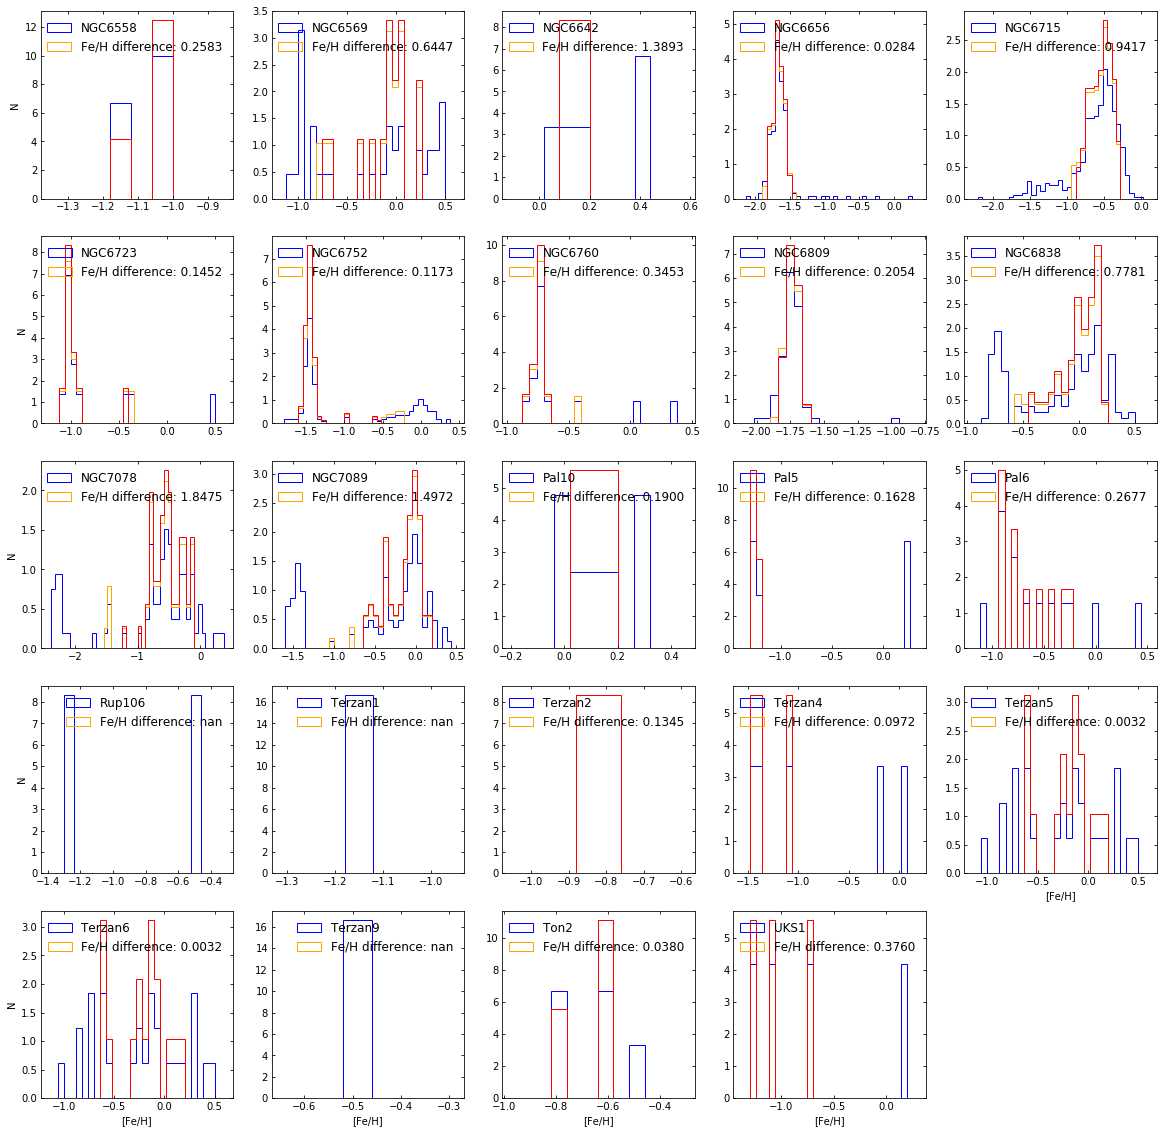

In [22]:
import matplotlib.gridspec as grid

# loop through the data and refine our GC sample in APOGEE using the MDF clipping method
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = grid.GridSpec(5,5)
p = 0
names = np.unique(name)
# loop over three batches of 25 GCs each to look at the MDF distribution and the sigma clipping procedure
names_1 = names[:25]
names_2 = names[25:50]
names_3 = names[50:]

for indx,i in enumerate(names_3):
    if i in data2['gc_name']:
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, Radial velocity)
        fehs = data2['FE_H']
        vlos = data2['VHELIO_AVG']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        vlos = vlos[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         determine the mean and sigma Fe/H values
        mean = np.mean(fehs)
        sigma = np.std(fehs)
#         select only those stars within 1 sigma from the mean [Fe/H] value
        fehs2 = fehs[np.fabs(mean-fehs)<(1.*sigma)]
        vlos2 = vlos[np.fabs(mean-fehs)<(1.*sigma)]
        names2 = gc_name[np.fabs(mean-fehs)<(1.*sigma)]
#         repeat the procedure and get the new mean and sigma [Fe/H] values to compare
        mean2 = np.mean(fehs2)
        sigma2 = np.std(fehs2)
#         again mask those stars which are within 2 sigmas of the new mean
        fehs3 = fehs2[np.fabs(mean2-fehs2)<=(2.*sigma2)]
        vlos3 = vlos2[np.fabs(mean2-fehs2)<(2.*sigma2)]
        names3 = names2[np.fabs(mean2-fehs2)<(2.*sigma2)]
#         calculate the final mean and sigma [Fe/H] values
        mean3 = np.mean(fehs3)
        sigma3 = np.std(fehs3)
        diff = np.array(np.fabs(mean3-fehs_h[names_h==i]))
    ax = fig.add_subplot(gs[p])
    ax.hist(fehs,50,range=(-2.5,0.5),histtype='step',color='b',label=str(i),density=True)
    ax.hist(fehs2,50,range=(-2.5,0.5),histtype='step',color='orange',density=True,label='Fe/H difference: '+str("%.4f" % diff))
    ax.hist(fehs3,50,range=(-2.5,0.5),histtype='step',color='red',density=True)
    ax.legend(loc='best',frameon=False,fontsize=12)
    ax.set_xlim(np.min(fehs)-0.2,np.max(fehs)+0.2)
    p+=1
axis = fig.axes
axis[0].set(ylabel='N')
axis[5].set(ylabel='N')
axis[10].set(ylabel='N')
axis[15].set(ylabel='N')
axis[20].set(ylabel='N')
axis[20].set(xlabel='[Fe/H]')
axis[21].set(xlabel='[Fe/H]')
axis[22].set(xlabel='[Fe/H]')
axis[23].set(xlabel='[Fe/H]')
axis[19].set(xlabel='[Fe/H]')

axis[0].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[1].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[2].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[3].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[4].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[5].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[6].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[7].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[8].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[9].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[10].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[11].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[12].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[13].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[14].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[15].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[16].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[17].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[18].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[19].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[20].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[21].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[22].tick_params(direction='in',axis='both',length=3,right=True,top=True)
axis[23].tick_params(direction='in',axis='both',length=3,right=True,top=True)
# axis[24].tick_params(direction='in',axis='both',length=3,right=True,top=True)

gs.update(wspace=0.2,hspace=0.2)

# plt.savefig('fig3', format='pdf', dpi=400, bbox_inches='tight')




# We will now remove all GC candidates which don't satisfy: |[Fe/H]apogee - [Fe/H]Harris| <0.5 dex. We then checke the MDF distribution for each GC, and decide how many sigma-clips we will apply to each GC. We will then loop through all the GCs and select the stars corresponding to the selected criteria

Note: the names in the no-clipped, 1-clipped and 2-clipped here are for the APOGEE catalogue, and will likely change between data releases. An analysis of each GC MDF is needed every time

# For GCs with no sigma clip. This includes GCs (or NSCs) such as omega-Cen, Terzan 5 and M54.

In [24]:
# set new savepath
savepath2 = '/Users/danny/Desktop/apogee-gc/dr17/clipped/'

In [26]:
names_noclip = ['NGC5139','NGC6558','NGC6715','Pal10','Terzan5']
names = np.unique(names_noclip)
for indx,i in tqdm.tqdm_notebook(enumerate(names)):
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s')            

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# For GCs requiring 1 sigma clip

In [27]:
names_1clip = ['NGC104','NGC5904','NGC6121','NGC6205','NGC6254','NGC6273','NGC6304','NGC6656','NGC6809']
names = np.unique(names_1clip)
for indx,i in tqdm.tqdm_notebook(enumerate(names)):
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         determine the mean and sigma Fe/H values
        mean = np.mean(fehs)
        sigma = np.std(fehs)
#         select only those stars within 1 sigma from the mean [Fe/H] value
        fehs2 = fehs[np.fabs(mean-fehs)<(1.*sigma)]
        apo_id2 = apo_id[np.fabs(mean-fehs)<(1.*sigma)]
        gc_name2 = gc_name[np.fabs(mean-fehs)<(1.*sigma)]
#         save the ids
        rec = np.recarray(len(apo_id2), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id2
        rec['name'] = gc_name2
        rec['fehs'] = fehs2
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s')        

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# For GCs requiring 2-sigma clips

In [28]:
names_2clip = ['HP1','Liller1','NGC1851','NGC1904','NGC2808','NGC288','NGC3201','NGC362','NGC4147','NGC4590','NGC5024',\
              'NGC5053','NGC5272','NGC5466','NGC6171','NGC6229','NGC6293','NGC6316','NGC6380','NGC6388','NGC6441',\
              'NGC6528','NGC6539','NGC6553','NGC6752','NGC6760','Pal5','Pal6','Terzan2','Terzan6','Ton2','UKS1']
names = np.unique(names_2clip)
for indx,i in tqdm.tqdm_notebook(enumerate(names)):
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         determine the mean and sigma Fe/H values
        mean = np.mean(fehs)
        sigma = np.std(fehs)
#         select only those stars within 1 sigma from the mean [Fe/H] value
        fehs2 = fehs[np.fabs(mean-fehs)<(1.*sigma)]
        apo_id2 = apo_id[np.fabs(mean-fehs)<(1.*sigma)]
        gc_name2 = gc_name[np.fabs(mean-fehs)<(1.*sigma)]
#         repeat the procedure and get the new mean and sigma [Fe/H] values to compare
        mean2 = np.mean(fehs2)
        sigma2 = np.std(fehs2)
#         again mask those stars which are within 2 sigmas of the new mean
        fehs3 = fehs2[np.fabs(mean2-fehs2)<=(2.*sigma2)]
        apo_id3 = apo_id2[np.fabs(mean2-fehs2)<(2.*sigma2)]
        gc_name3 = gc_name2[np.fabs(mean2-fehs2)<(2.*sigma2)]
#         save the ids
        rec = np.recarray(len(apo_id3), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id3
        rec['name'] = gc_name3
        rec['fehs'] = fehs3
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s')  

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


# NOTE: For some GCs, the sigma clipping did not target the actual GC star members, this is because of contamination in the sample. For those GCs, we select only those stars with metallicities around the Harris catalogue value (within ~0.5 dex).

In [32]:
names_o = ['NGC6218','NGC6341','NGC6397','NGC6522','NGC6540','NGC6544','NGC6569','NGC6723','NGC6838']
names = np.unique(names_o)
for indx,i in tqdm.tqdm_notebook(enumerate(names)):
    if i=='NGC6569':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-0.5
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s')  
    elif i=='NGC6522' or i=='NGC6838':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-0.7
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s') 
    elif i=='NGC6723' or i=='NGC6540':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-0.8
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s') 
    elif i=='NGC6544':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-0.9
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s') 
    elif i=='NGC6218':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-1
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s') 
    elif i=='NGC6397':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-1.5
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s')
    elif i=='NGC6341':
#         get the necessary information from each star in the sample (i.e. Fe/H, GC name, APOGEE ID)
        fehs = data2['FE_H']
        apo_id = data2['APOGEE_ID']
        gc_name = data2['gc_name']
#         find the stars associated with each GC
        fehs = fehs[np.where(data2['gc_name']==i)]
        apo_id = apo_id[np.where(data2['gc_name']==i)]
        gc_name = gc_name[np.where(data2['gc_name']==i)]
#         create a mask to select only those stars that are GC members
        mask = fehs<-2
        fehs = fehs[mask]
        apo_id = apo_id[mask]
        gc_name = gc_name[mask]
        #         save the ids
        rec = np.recarray(len(apo_id), dtype=[('apogee_id',object),('name', object),('fehs', object)])
        rec['apogee_id'] = apo_id
        rec['name'] = gc_name
        rec['fehs'] = fehs
        np.savetxt(savepath2+i+'.txt',rec,fmt='%s') 


/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


join all the text files into one

In [33]:
# saved the clipped sample
import glob
import sys
files = glob.glob(savepath2+'*.txt')
complete2=[]
for i in files:
    file = np.array(np.loadtxt(i,dtype='str'))
    complete2.extend(file)
    

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/clipped/NGC4147.txt"
  import sys
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/clipped/NGC6293.txt"
  import sys
/Users/danny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "/Users/danny/Desktop/apogee-gc/dr17/clipped/Terzan6.txt"
  import sys


Concatenate the files and save it as one full sample

In [35]:
# save the full clipped sample together in one file
print('There are '+str(len(complete2))+' stars in Galactic GCs in the final sample')
np.savetxt('/Users/danny/Desktop/apogee-gc/dr17/clipped/complete.txt',complete2,fmt='%s')


There are 4196 stars in Galactic GCs in the final sample


# Now merge the file with the APOGEE (or other data set) in topcat and you have your GC catalogue!